In [6]:
import os
import sys
import h5py
import numpy as np
import matplotlib as mpl
path = '/tigress/ruix/vis/'
os.chdir(path)
import matplotlib.pyplot as plt
plt.style.use('apw-notebook.mplstyle')
%matplotlib inline
%run LoadNotebook
import DataProcess as R
#import matplotlib.cm as cmaps
#from  matplotlib.colors import LogNorm
from ipywidgets import widgets,interact,fixed
from IPython.display import display

In [7]:
'''
This function plot electron/ion momtum and energy spectrum.
'''
def Plot_Spectrum(index, xL=0.,xR=1000,shock=1,frame=''):

    #Dt = R.readparam('time',ind+1)-R.readparam('time',index)
    mom,gamma,momedist,mompdist,edist,pdist = R.spect1d(index,xL,xR,shock,frame)
    fig,ax = plt.subplots(2,sharex=True)

    # electron/ion energy spectrum
    #ax[0].loglog(gamma,edist,linewidth=2,linestyle='-',color=mpl.cm.autumn(i/ float(nsteps)))
    ax[0].loglog(gamma,edist)
    ax[0].loglog(gamma,pdist)
    # electron/ion momentum spectrum
    ax[1].loglog(mom,momedist)
    ax[1].loglog(mom,mompdist)
   
    #ax[0].axis([1e-4,1e2,1e-6,1e0])
    ax[0].set_ylabel(r'$E(dn/dE)/n$')
    ax[0].set_xlabel(r'$\gamma-1$')

    ax[1].axis([1e-2,1e2,1e-6,1e0])
    ax[1].set_ylabel(r'$p^4 f(p)$')
    ax[1].set_xlabel(r'$\gamma\beta$')
    plt.show()

In [8]:
'''
Phase plot of ions and electrons
'''
def Plot_Phase(ind, sp, mom_dim, GammaBoost=0., pbins=200, xbins=200):
    u = R.readprtl('u'+sp,ind)
    v = R.readprtl('v'+sp,ind)
    w = R.readprtl('w'+sp,ind)
    x_values = R.readprtl('x'+sp,ind)/R.readparam('c_omp')
    # x_min & x_max before boostin'
    xmin = 0
    xmax = R.readflds('bx',ind).shape[1]/R.readparam('c_omp')*R.readparam('istep')
    # First calculate beta and gamma
    if GammaBoost>=1:
        betaBoost = np.sqrt(1.-1/GammaBoost**2)
    elif GammaBoost >-1:
        betaBoost = GammaBoost
        GammaBoost = np.sqrt(1.-betaBoost**2)**(-1)
    else:
        betaBoost = -np.sqrt(1.-1/GammaBoost**2)
        GammaBoost *= -1.

    # Now calculate gamma of the particles in downstream restframe
    gamma_ds = np.sqrt(u**2+v**2+w**2+1.)
    # calculate the velocities from the momenta
    vx = u/gamma_ds
    vy = v/gamma_ds
    vz = w/gamma_ds

    # Now calulate the velocities in the boosted frames
    tmp_helper = 1-vx*betaBoost
    vx_prime = (vx-betaBoost)/tmp_helper
    vy_prime = vy/GammaBoost/tmp_helper
    vz_prime = vz/GammaBoost/tmp_helper

    # Now calculate the LF in the boosted frames using rapidity
    # Initial rapidity
    rap_prtl = np.arccosh(gamma_ds)
    rap_boost = np.arccosh(GammaBoost)

    #v_tot_sq = vx_prime**2 + vy_prime**2 + vz_prime**2
    #gamma_old_way = 1/np.sqrt(1-v_tot_sq)

    gamma_prime = gamma_ds*GammaBoost-np.sign(u)*np.sign(betaBoost)*\
         np.sinh(rap_prtl)*np.sinh(rap_boost)/np.sqrt(1+(v/u)**2+(w/u)**2)

    if mom_dim == 0:
        y_values  = vx_prime*gamma_prime
    if mom_dim == 1:
        y_values  = vy_prime*gamma_prime
    if mom_dim == 2:
        y_values  = vz_prime*gamma_prime

    # Some of the values are becoming NaN.
    # ignore them, but I don't think this should be happening anymore....
    outRange = np.isnan(y_values)

    pmin = min(y_values)
    pmax = max(y_values)
    
    hist2d = np.histogram2d(y_values[~outRange], x_values[~outRange],
        bins = [pbins, xbins],range = [[pmin,pmax],[xmin,xmax]])
    
    plt.imshow(hist2d[0], interpolation='hermite', origin='low',aspect='auto',extent=[xmin, xmax, pmin, pmax])

In [9]:
def Plot_FFT(ind, param, xL=0, xR=1000, case=0):
    fig,ax = plt.subplots(2,sharex= True)
    k_axis, Bfft = R.fft_flds(ind, param, xL,xR,case)
    ax[0].semilogx(k_axis,Bfft)
    ax[0].set_ylabel(r'$\delta B/B_0$')
    print ('Maximum Wavelength=',2.*np.pi/np.abs(k_axis[np.argmax(Bfft)]))

    k_axis, Chi = R.polarization(ind,xL,xR, case)
    ax[1].semilogx(k_axis,Chi)
    ax[1].set_xlabel(r'$k[c/\omega_{pe}]$')
    ax[1].set_ylabel(r'$\chi$')
    #ax[1].axvline(x=np.abs(k_axis[np.argmax(Bfft)]),color='r',linestyle='--',linewidth=2)
    

In [10]:
def CreateMovie(plotter, fname, numberOfFrames, Interval=1, StartInd=1, fps=5):
    for i in range(numberOfFrames):
        print('Movie making index: i=',i)
        plotter(i*Interval+StartInd)
        plt.savefig(fname+str(i).zfill(3)+'.png',format='png')
        plt.clf()
    #os.system("rm movie.mp4")
    os.system("ffmpeg -framerate "+str(fps)+" -i "+fname+"%03d.png movie.mp4")
    os.system("rm *.png")

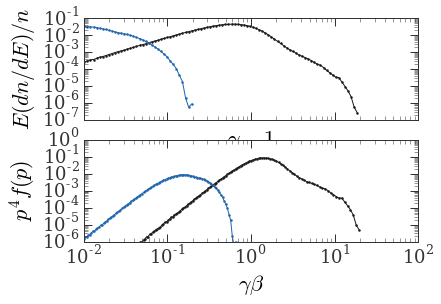

<function __main__.Plot_Spectrum>

In [11]:
# switch to data directory
path = '/tigress/ruix/simu/1dang70mass100new/output/'
os.chdir(path)


# Interactive analysis of Spectrum
#interact(P.Plot_Spectrum, ind=widgets.IntSlider(min=1,max=100,step=1,value=10))
interact(Plot_Spectrum, index=widgets.IntSlider(min=1,max=200,step=2,value=10,continuous_update=False),\
         xL=widgets.FloatSlider(min=-5000,max=5000,step=100,value=0,continuous_update=False),\
         xR=widgets.FloatSlider(min=-5000,max=5000,step=100,value=1000,continuous_update=False),\
         shock=widgets.IntSlider(min=0,max=1,step=1,continous_update=False), frame=fixed(''))


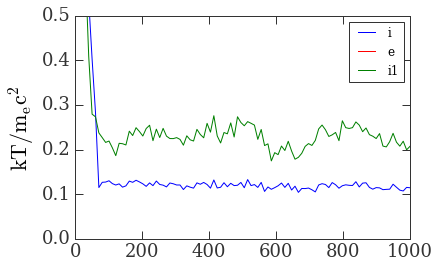

In [12]:
# calculate e/i pressure
# switch to data directory
path = '/tigress/ruix/simu/1dang70mass100new/output/'
os.chdir(path)
ind = 500
xbins= 100
xL = 0
xR = 1000
#Tmpe = R.prtl_tmp_rel(ind,'e',xbins,xL=0, xR=1000,shock=1,frame='upstream')
#Tmpe1 = R.prtl_tmp(ind,'e',xbins,direct='prl')
Tmpi = R.prtl_tmp_rel(ind,'i',xbins,xL,xR)
Tmpe = R.prtl_tmp_rel(ind,'e',xbins,xL,xR)

Tmpe1 = R.prtl_tmp(ind,'e',xbins,direct='x')
Tmpi1 = R.prtl_tmp(ind,'i',xbins,direct='x')
x_values = np.linspace(xL,xR,xbins)
#plt.plot(x_values, Tmpe,'k-',label='e')
#plt.plot(x_values, Tmpe1,'r-',label='e')
plt.plot(x_values, Tmpi,'b-',label='i')
plt.plot(x_values, Tmpe,'r-',label='e')
#plt.plot(x_values, Tmpe1,'k-',label='e1')
plt.plot(x_values, Tmpi1,'g-',label='i1')
plt.ylim([0,0.5])
#plt.plot(x_values, Tiy,'r--',label='i2')
plt.legend()
plt.ylabel(r'$\rm{kT/m_ec^2}$')
plt.show()

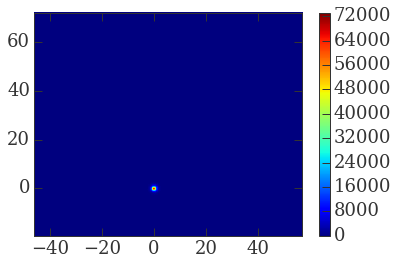

In [13]:
# switch to data directory
path = '/tigress/ruix/simu/1dang70mass100new/output/'
os.chdir(path)
ind =100
sp = 'e'
u  = R.readprtl('u'+sp,ind)
v  = R.readprtl('v'+sp,ind)
w  = R.readprtl('w'+sp,ind)
plt.hist2d(u, v, bins=400) #, norm=LogNorm())
#plt.ylim([-5,5])
#plt.xlim([-5,5])
plt.colorbar()
plt.show()

In [ ]:
import os
path = '/tigress/ruix/simu/1dang70mass100new/output/'
os.chdir(path)
xbins =100
xL = 0
xR = 1000
num = 99
Tmpe = np.zeros(num)
Tmpi = np.zeros(num)
time = np.zeros(num)
for ind in range(0,num):
    Tmpe[ind] = R.prtl_tmp_geneal_rel(ind*8+1,'e',xL, xR,shock=1,frame='rest')
    Tmpi[ind] = R.prtl_tmp_geneal_rel(ind*8+1,'i',xL, xR,shock=1,frame='rest')
    time[ind] = R.readparam('time',ind*8+1)
plt.plot(time, Tmpe/Tmpi)
plt.xlabel('Time$[\omega_{pe}^{-1}]$')
plt.ylabel('$T_e/T_i$')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

('zeroth momentum:', 0.96747222033075353)
('zeroth momentum:', 0.96721261966115779)
('zeroth momentum:', 0.96442195231292238)
('zeroth momentum:', 0.96410663189028301)
('zeroth momentum:', 0.96313598665236488)
('zeroth momentum:', 0.96278946385417985)
('zeroth momentum:', 0.96239965092770985)
('zeroth momentum:', 0.9620348535079899)
('zeroth momentum:', 0.96172248156582973)
('zeroth momentum:', 0.96134741120865397)
('zeroth momentum:', 0.96174251968917501)
('zeroth momentum:', 0.96136003850065721)
('zeroth momentum:', 0.96127370335073625)
('zeroth momentum:', 0.96088266177729553)
('zeroth momentum:', 0.96121757808704322)
('zeroth momentum:', 0.96082388775995475)
('zeroth momentum:', 0.96094299108922121)
('zeroth momentum:', 0.96053839992958634)
('zeroth momentum:', 0.96080950866927339)
('zeroth momentum:', 0.9604074635975326)
('zeroth momentum:', 0.96080651888056157)
('zeroth momentum:', 0.9604009084896139)
('zeroth momentum:', 0.96062979150242434)
('zeroth momentum:', 0.96022123733320

In [24]:
import os
path = '/tigress/ruix/simu/1dang70mass100new/output/'
os.chdir(path)
ind = 4
xbins =100
xL = 0
xR = 1000
Tmp = R.prtl_tmp_geneal_rel(ind,'e',xL, xR,shock=1,frame='')
print Tmp, 'vthe=',np.sqrt(Tmp)
Tmp = R.prtl_tmp_geneal_rel(ind,'i',xL, xR,shock=1,frame='')
print Tmp, 'vthi', np.sqrt(Tmp/100.)

#PMag = np.mean(R.readparam('bx')+R.readparam('by')+R.readparam('bz'))


('zeroth momentum:', 0.96599131630271606)
0.186617901299 vthe= 0.43199294126
('zeroth momentum:', 0.96570826215121564)
0.820674950018 vthi 0.0905911115959
